# Step 1 - Text Preprocessing

In [1]:
import pandas as pd
import langdetect
import nltk
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator
from nltk.stem import WordNetLemmatizer
from IPython.display import clear_output

[nltk_data] Downloading package punkt to /home/stanislav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/stanislav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def show_percentage(m, n):
    clear_output(wait=True)
    k = m / (n - 1)
    percent = int(k * 100)
    print('[' + 'x'*percent + '-'*(100 - percent) + ']' + " {:.2%}".format(k))
    print("{}/{} complete".format(m + 1, n))

### Get the Data

In [3]:
# https://www.kaggle.com/adarshsng/predicting-job-type-category-by-job-description
df = pd.read_csv("data/raw_data.csv")
df.head()

,job_no,job_description,job_type,category
0,Id-12765,Zest Scientific is searching for an accomplis...,Permanent,"Pharmaceutical, Healthcare and Medical Sales"
1,Id-22925,"En el mundo de los CRO's típicos, esta compañí...",Permanent,Clinical Research
2,Id-1321,Asha Mistry of Umbilical Life is recruiting an...,Contract/Interim,Pharmaceutical Marketing
3,Id-9473,Sales Representative - Laser in der Medizinte...,Permanent,"Pharmaceutical, Healthcare and Medical Sales"
4,Id-14952,Field Service Engineer - Life Science\r\r\r\nC...,Permanent,Manufacturing & Operations


In [4]:
df.isnull().sum()

job_no             0
job_description    0
job_type           0
category           0
dtype: int64

In [5]:
df['job_description'][0][:300]

" Zest Scientific is searching for an accomplished Scientific Sales professional in the Netherlands. This territory will play a pivotal role as the company increases their presence across Europe, presenting a wealth of untapped potential. Our client is internationally recognized for providing 'best i"

In [6]:
df.shape

(17657, 4)

In [7]:
df['job_type'].value_counts()

Permanent             15777
Contract/Interim       1414
Contract/Temp           305
Temporary/Seasonal      113
Any                      25
Part-Time                23
Name: job_type, dtype: int64

In [8]:
df['category'].value_counts()

Pharmaceutical, Healthcare and Medical Sales    4507
Clinical Research                               3172
Science                                         2932
Manufacturing & Operations                      2235
Regulatory Affairs                              1163
Pharmaceutical Marketing                        1071
Data Management and Statistics                   829
Quality-assurance                                703
Medical Information and Pharmacovigilance        561
Medical Affairs / Pharmaceutical Physician       458
Pharmacy                                          26
Name: category, dtype: int64

### Translate foreign texts 

In [9]:
def translate_to_eng(text):
    translated = GoogleTranslator(source="auto", target="en").translate(text)
    return translated


for i in range(len(df)):
    text = df.iloc[i]["job_description"]
    if langdetect.detect(text) != "en":
        # NotValidPayload: . --> text must be a valid text with maximum 5000 character, otherwise it cannot be translated
        if len(text) > 4900:
            new_text = ""
            for j in range(len(text) // 4900 + 1):
                text_j = text[j * 4900 : (j + 1) * 4900]
                new_text += translate_to_eng(text_j)
            df.iloc[i]["job_description"] = new_text
        else:
            df.iloc[i]["job_description"] = translate_to_eng(text)
    show_percentage(i, len(df))

[xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx] 100.00%
17657/17657 complete


### Clear the Text

In [10]:
def remove_punctuation(text):
    punctuationfree = "".join([i for i in text if i not in string.punctuation])
    return punctuationfree


df['job_description'] = df['job_description'].apply(lambda x: remove_punctuation(x))
# lowering the text
df['job_description'] = df['job_description'].apply(lambda x: x.lower())
df['job_description'][0][:300]

' zest scientific is searching for an accomplished scientific sales professional in the netherlands this territory will play a pivotal role as the company increases their presence across europe presenting a wealth of untapped potential our client is internationally recognized for providing best in cl'

### Tokenization

In [11]:
df['job_description'] = df['job_description'].apply(lambda x: word_tokenize(x))
print(df['job_description'][0][:20])

['zest', 'scientific', 'is', 'searching', 'for', 'an', 'accomplished', 'scientific', 'sales', 'professional', 'in', 'the', 'netherlands', 'this', 'territory', 'will', 'play', 'a', 'pivotal', 'role']


In [12]:
def clear(lst):
    new_lst = []
    for word in lst:
        if word.isalpha() and len(word) > 1:
            new_lst.append(word)
    return new_lst


df['job_description'] = df['job_description'].apply(lambda x: clear(x))
print(df['job_description'][0][:20])

['zest', 'scientific', 'is', 'searching', 'for', 'an', 'accomplished', 'scientific', 'sales', 'professional', 'in', 'the', 'netherlands', 'this', 'territory', 'will', 'play', 'pivotal', 'role', 'as']


### Remove stop words

In [13]:
stopwords_en = nltk.corpus.stopwords.words('english')

def remove_stopwords(lst):
    output = [i for i in lst if i not in stopwords_en]
    return output


df['job_description'] = df['job_description'].apply(lambda x: remove_stopwords(x))
print(df['job_description'][0][:20])

['zest', 'scientific', 'searching', 'accomplished', 'scientific', 'sales', 'professional', 'netherlands', 'territory', 'play', 'pivotal', 'role', 'company', 'increases', 'presence', 'across', 'europe', 'presenting', 'wealth', 'untapped']


### Lemmatization

In [14]:
lemmatizer = WordNetLemmatizer()
def lemmatize(lst):
    lemm_text = [lemmatizer.lemmatize(word) for word in lst]
    return lemm_text


df['job_description'] = df['job_description'].apply(lambda x: lemmatize(x))
print(df['job_description'][0][:20])

['zest', 'scientific', 'searching', 'accomplished', 'scientific', 'sale', 'professional', 'netherlands', 'territory', 'play', 'pivotal', 'role', 'company', 'increase', 'presence', 'across', 'europe', 'presenting', 'wealth', 'untapped']


## Visualization

In [16]:
def build_wordcloud(text, collocations):
    wordcloud = WordCloud(
        max_words=50,
        font_step=2,
        max_font_size=500,
        background_color='black',
        collocations=collocations
    ).generate(text)
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(wordcloud);
    plt.show()


def visualize_category(df, collocations):
    for label in df['category'].unique():
        print(label)
        text = ''
        for msg in df[df['category'] == label]['job_description']:
            text += " ".join(msg)
        build_wordcloud(text, collocations)

### Common words

Pharmaceutical, Healthcare and Medical Sales


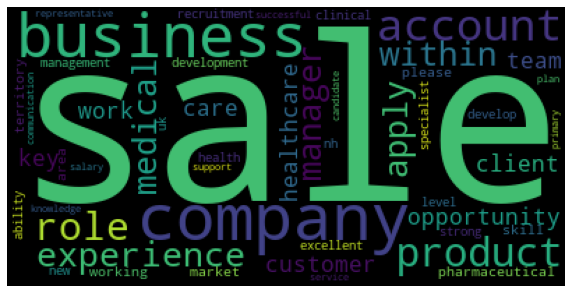

Clinical Research


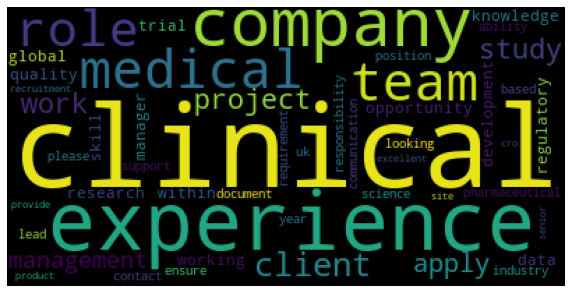

Pharmaceutical Marketing


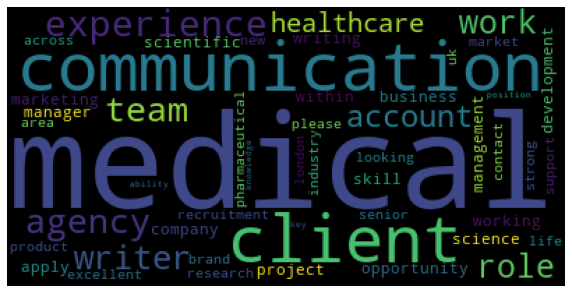

Manufacturing & Operations


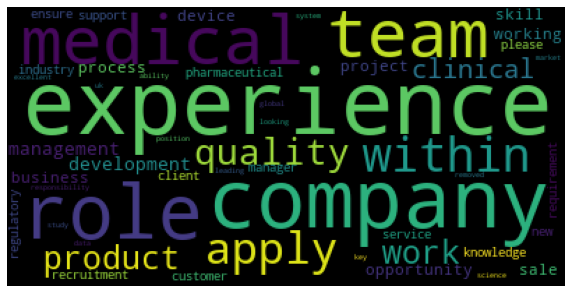

Science


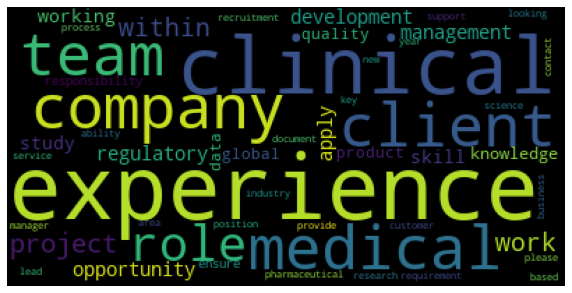

Medical Affairs / Pharmaceutical Physician


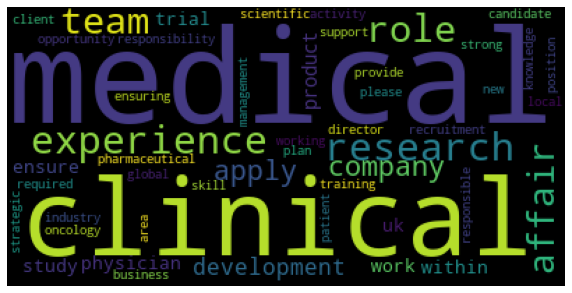

Regulatory Affairs


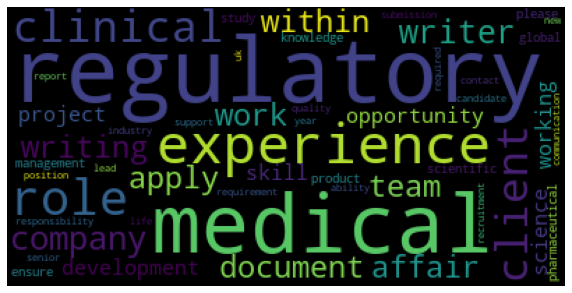

Medical Information and Pharmacovigilance


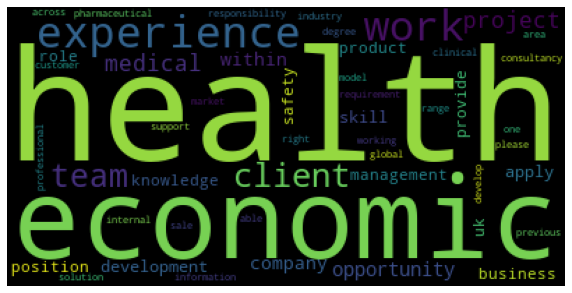

Data Management and Statistics


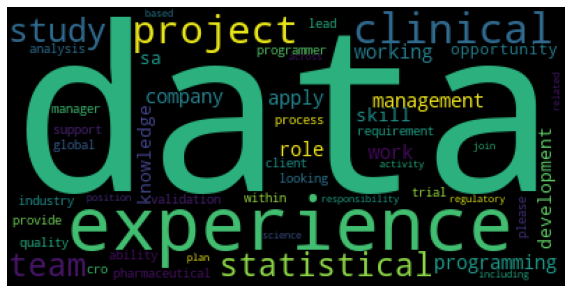

Quality-assurance


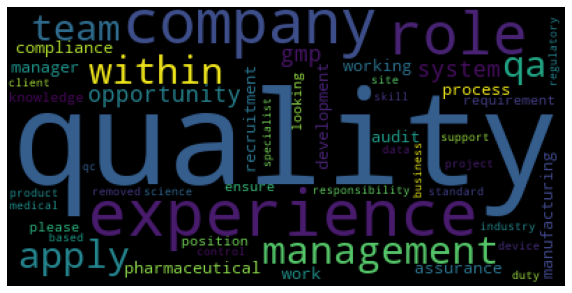

Pharmacy


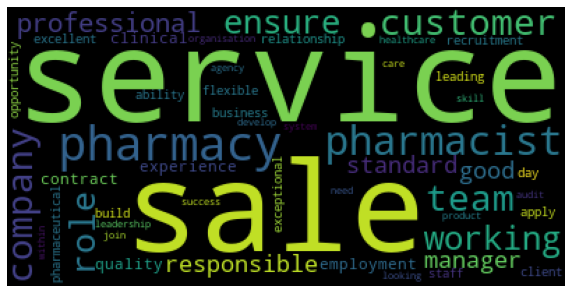

In [17]:
visualize_category(df, False)

### Bi-grams

Pharmaceutical, Healthcare and Medical Sales


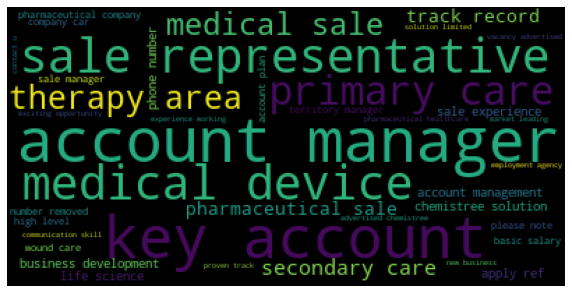

Clinical Research


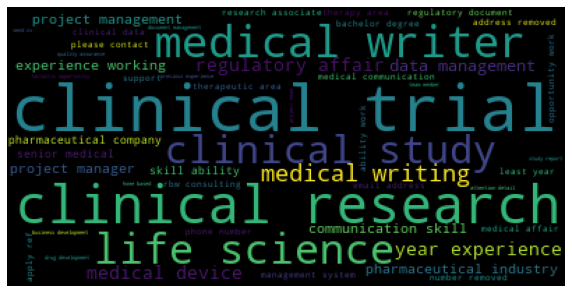

Pharmaceutical Marketing


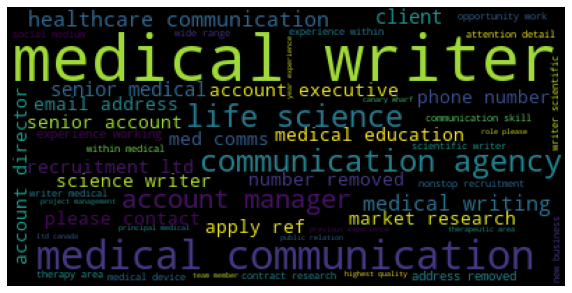

Manufacturing & Operations


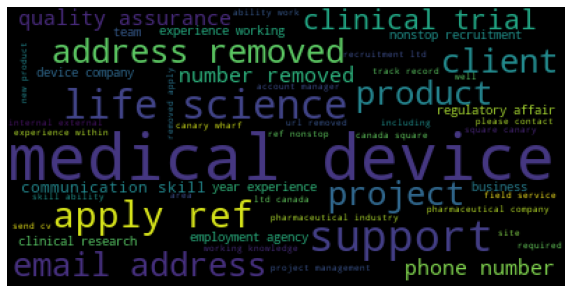

Science


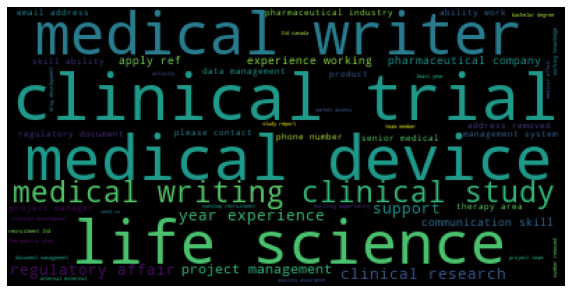

Medical Affairs / Pharmaceutical Physician


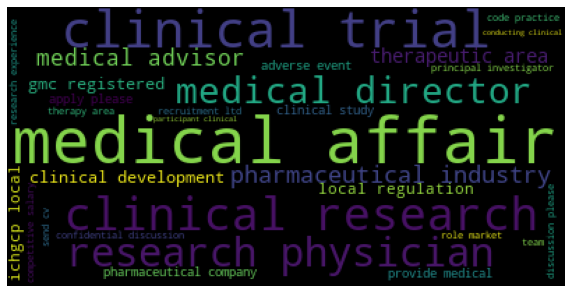

Regulatory Affairs


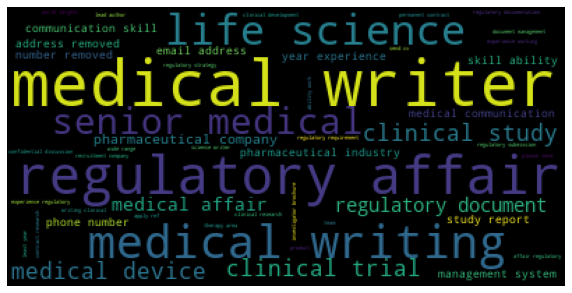

Medical Information and Pharmacovigilance


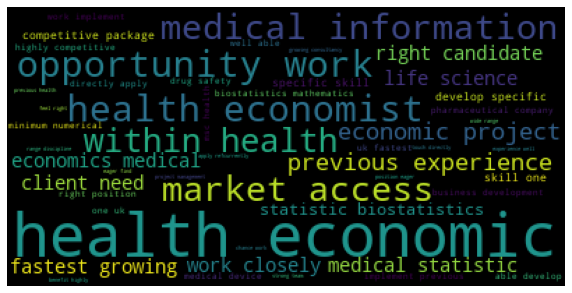

Data Management and Statistics


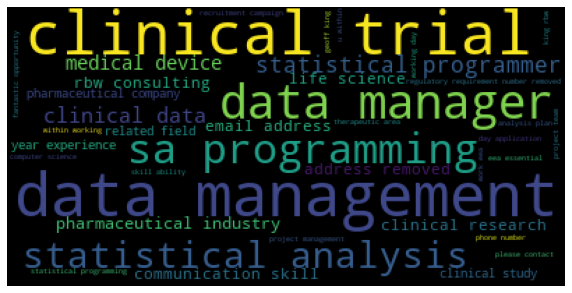

Quality-assurance


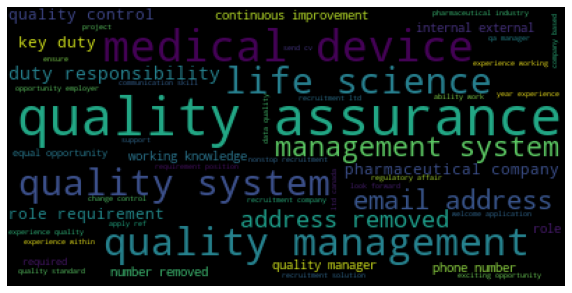

Pharmacy


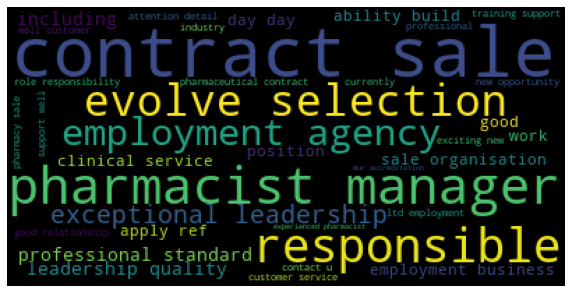

In [18]:
visualize_category(df, True)

In [19]:
# save preprocessed data
df.to_csv("data/preprocessed_data.csv", index=False)